In [63]:
pip install numpy pandas matplotlib seaborn opencv-python scikit-learn imageHash


Note: you may need to restart the kernel to use updated packages.


In [83]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from pathlib import Path
from skimage.exposure import histogram
from tqdm import tqdm




In [9]:
print("Current working directory:", os.getcwd())


Current working directory: F:\Brain_Tumour\Brain_Tumor_Classification\notebooks


In [11]:
healthy_dir = "F:/Brain_Tumour/Brain_Tumor_Classification/data/raw/no_tumor/"
tumor_dir = "F:/Brain_Tumour/Brain_Tumor_Classification/data/raw/yes_tumor/"

healthy_images = os.listdir(healthy_dir)
tumor_images = os.listdir(tumor_dir)

print(f"found {len(healthy_images)} healthy images")
print(f"found {len(tumor_images)} tumor images")

found 65 healthy images
found 130 tumor images


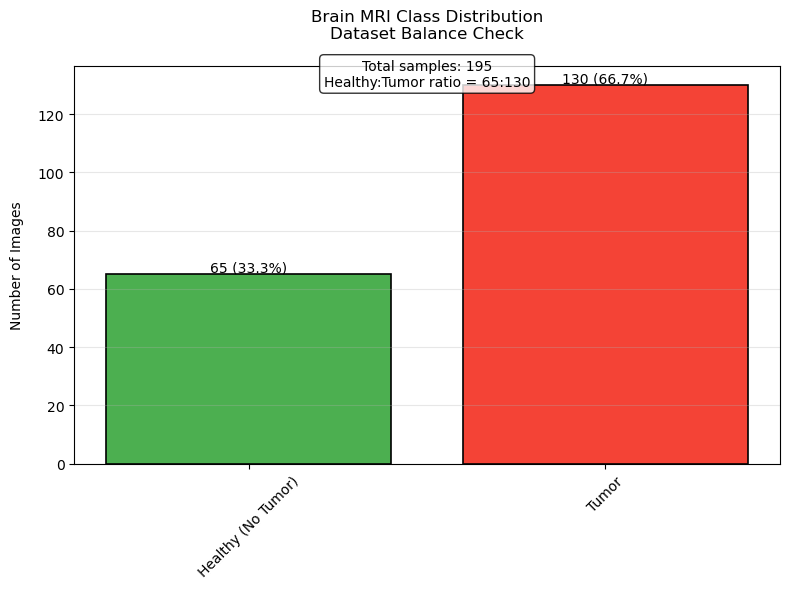

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ['Healthy (No Tumor)', 'Tumor']
counts = [len(healthy_images), len(tumor_images)]
colors = ['#4CAF50', '#F44336']  # Professional green/red

# Create figure
plt.figure(figsize=(8, 6), dpi=100)

# Bar plot with improved styling
bars = plt.bar(labels, counts, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height} ({height/sum(counts):.1%})',
             ha='center', va='bottom')

# Styling
plt.title('Brain MRI Class Distribution\nDataset Balance Check', pad=20)
plt.ylabel('Number of Images', labelpad=10)
plt.xticks(rotation=45)  # Prevent label crowding
plt.grid(axis='y', alpha=0.3)

# Add analysis note
plt.annotate(f'Total samples: {sum(counts)}\nHealthy:Tumor ratio = {counts[0]}:{counts[1]}',
             xy=(0.5, 0.95), xycoords='axes fraction',
             ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()  # Prevent label cutoff
plt.show()

In [15]:
#### Step 2 Analyze Image sizes and channesls
import os
import cv2
import pandas as pd
from tqdm import tqdm

image_info = []

# Function to extract size and channel info
def analyze_directory(path, label):
    for filename in tqdm(os.listdir(path), desc=f"Checking {label}"):
        full_path = os.path.join(path, filename)
        try:
            img = cv2.imread(full_path)
            if img is not None:
                h, w, c = img.shape
                image_info.append({
                    "filename": filename,
                    "label": label,
                    "height": h,
                    "width": w,
                    "channels": c
                })
            else:
                print(f"⚠️ Corrupted or unreadable: {filename}")
        except Exception as e:
            print(f"Error reading {filename}: {e}")

# Run it on both folders
analyze_directory(healthy_dir, "No Tumor")
analyze_directory(tumor_dir, "Tumor")

# Convert to DataFrame
df_images = pd.DataFrame(image_info)
df_images.head()


Checking Tumor: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 215.67it/s]


,filename,label,height,width,channels
0,11 no.jpg,No Tumor,168,300,3
1,12 no.jpg,No Tumor,183,275,3
2,14 no.jpg,No Tumor,197,177,3
3,15 no.jpg,No Tumor,217,232,3
4,18 no.jpg,No Tumor,221,228,3


In [17]:
df_images.groupby("label")[["height", "width"]].describe()


height                                                                \
          count        mean         std    min     25%    50%     75%     max   
label                                                                           
No Tumor   65.0  331.584615  193.475280  168.0  225.00  244.0  400.00  1080.0   
Tumor     130.0  396.384615  207.936871  173.0  290.25  340.0  369.75  1427.0   

          width                                                               
          count        mean         std    min    25%    50%     75%     max  
label                                                                         
No Tumor   65.0  336.353846  264.726240  150.0  208.0  225.0  400.00  1920.0  
Tumor     130.0  343.807692  189.659797  178.0  244.5  280.0  318.75  1275.0

In [19]:
df_images.groupby(["label", "channels"]).size()


label     channels
No Tumor  3            65
Tumor     3           130
dtype: int64

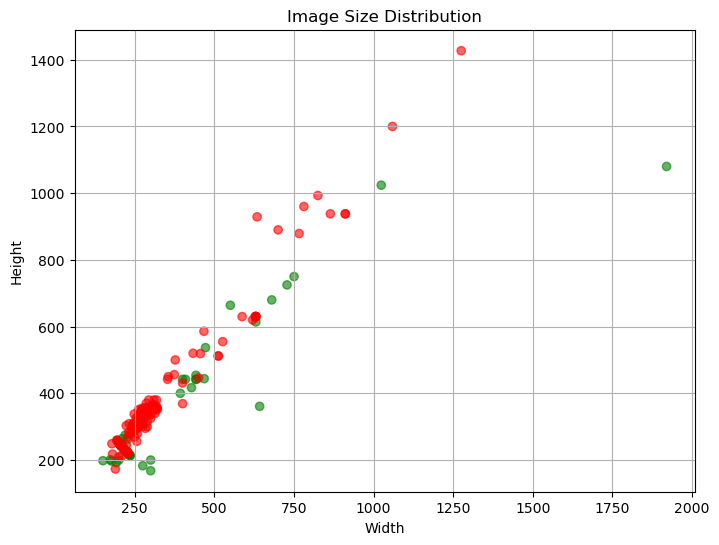

In [21]:
import matplotlib.pyplot as plt

colors = df_images['label'].map({'Tumor': 'red', 'No Tumor': 'green'})
plt.figure(figsize=(8,6))
plt.scatter(df_images['width'], df_images['height'], c=colors, alpha=0.6)
plt.title("Image Size Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(True)
plt.show()


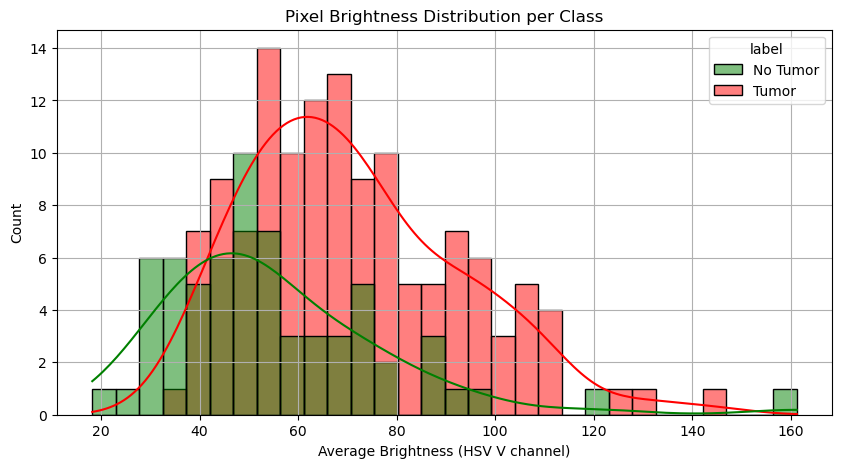

In [25]:
import numpy as np

def compute_brightness(path):
    img = cv2.imread(path)
    if img is not None:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        brightness = hsv[..., 2].mean()
        return brightness
    return None

# Compute brightness per image
df_images["brightness"] = df_images.apply(lambda row: compute_brightness(
    os.path.join(healthy_dir if row["label"] == "No Tumor" else tumor_dir, row["filename"])
), axis=1)

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(data=df_images, x="brightness", hue="label", bins=30, kde=True, palette={"Tumor": "red", "No Tumor": "green"})
plt.title("Pixel Brightness Distribution per Class")
plt.xlabel("Average Brightness (HSV V channel)")
plt.grid(True)
plt.show()


In [35]:
print(df_images.groupby('label')['brightness'].describe())

          count       mean        std        min        25%        50%  \
label                                                                    
No Tumor   65.0  55.333105  23.511752  18.232738  39.605684  50.664697   
Tumor     130.0  71.092387  21.752646  34.054301  54.531170  67.212317   

                75%         max  
label                            
No Tumor  66.401284  161.198867  
Tumor     84.924528  143.772541  


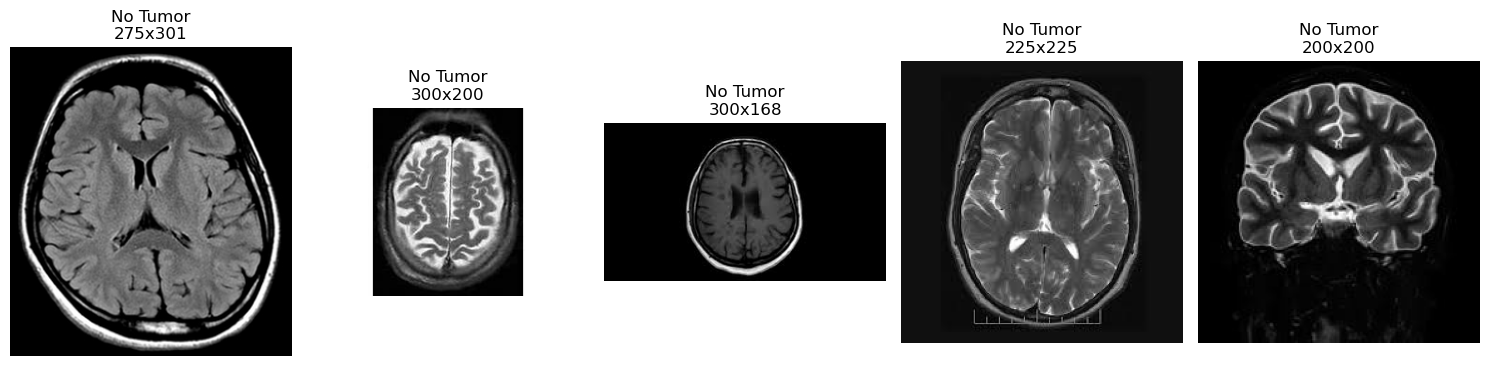

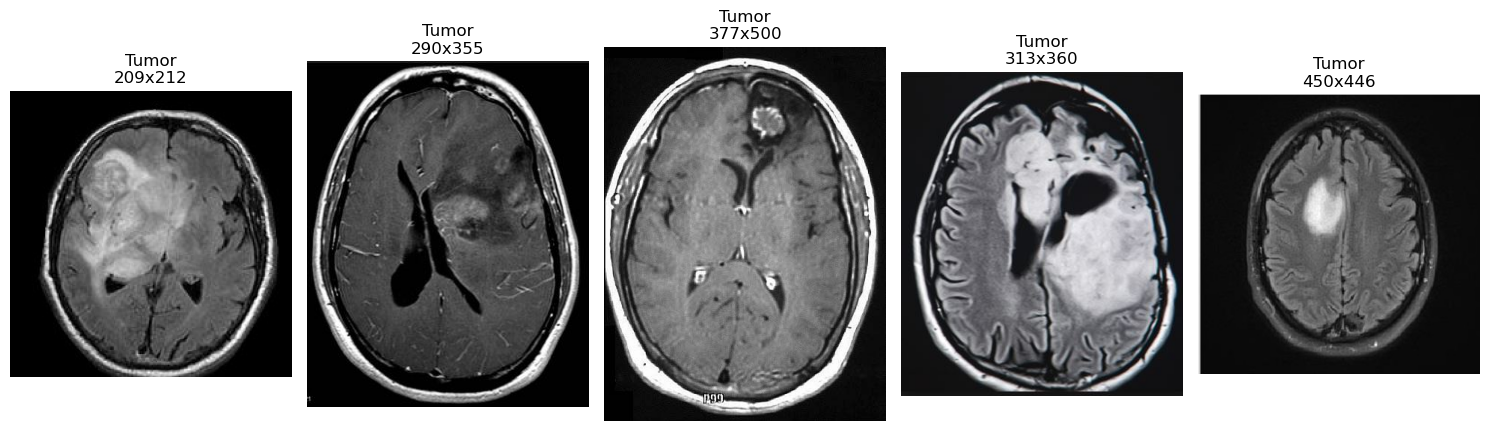

In [31]:
## Sample Visualization.

def show_random_images(df, label, n=5):
    subset = df[df['label'] == label].sample(n, random_state=42)
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(subset.iterrows()):
        path = os.path.join(healthy_dir if label == "No Tumor" else tumor_dir, row['filename'])
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"{label}\n{row['width']}x{row['height']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show examples
show_random_images(df_images, "No Tumor", n=5)
show_random_images(df_images, "Tumor", n=5)


In [39]:
### Contrast Analyse
def compute_contrast(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        return img.std()
    return None

# Add contrast column
df_images["contrast"] = df_images.apply(lambda row: compute_contrast(
    os.path.join(healthy_dir if row["label"] == "No Tumor" else tumor_dir, row["filename"])
), axis=1)


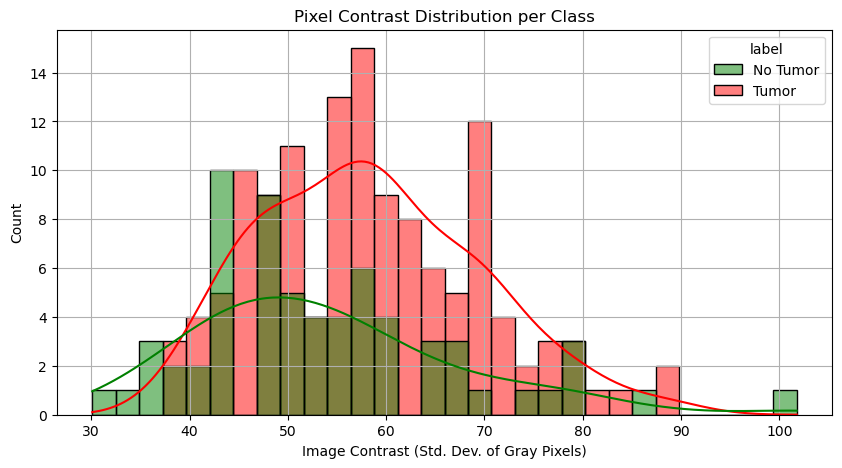

In [41]:
plt.figure(figsize=(10,5))
sns.histplot(data=df_images, x="contrast", hue="label", bins=30, kde=True,
             palette={"Tumor": "red", "No Tumor": "green"})
plt.title("Pixel Contrast Distribution per Class")
plt.xlabel("Image Contrast (Std. Dev. of Gray Pixels)")
plt.grid(True)
plt.show()


In [43]:
## check for Exact Duplication 
import hashlib

def file_hash(path):
    with open(path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

df_images["hash"] = df_images.apply(
    lambda row: file_hash(os.path.join(
        healthy_dir if row['label'] == 'No Tumor' else tumor_dir, row['filename']
    )),
    axis=1
)

# Check duplicates
duplicates = df_images[df_images.duplicated("hash", keep=False)].sort_values("hash")
print(f"Found {duplicates.shape[0]} potentially duplicate images.")
duplicates[["filename", "label", "hash"]]


Found 0 potentially duplicate images.


,filename,label,hash


In [ ]:
## EDA Conclusion

- **Dataset**: 65 healthy / 130 tumor images  
- **Dimensions**: Varied sizes (needs resizing)  
- **Brightness**: Tumor images are brighter (μ=71.1 vs 55.3)  
- **Duplicates**: None detected  
- **Recommendations**:  
  - Class-aware normalization  
  - Oversample healthy cases  
  - Standardize to 256x256  